# Convolutional Neural Networks

이번에는 이미지 인식 분야에서 가장 성공적으로 쓰이고 있는 Convolutional Neural Networks를 실습해본다.  
Convolutional Neural Networks, CNN은 아래와 같은 Convolutional Layer를 여러층 가진 딥러닝 모델을 뜻한다.


이번에는 간단한 구조를 가진 CNN을 구현한다.
MNIST 데이터를 이용하여 학습하고 테스팅 해본다. 

사용된 기술

- conv2d
- max-pool
- weight 초기화: truncated normal dist.
- RMSProp optimizer

- one epoch에 55,000장의 이미지중 랜덤하게 128개를 선택해서 사용 한다.
- 메모리 문제로 10,000개의 testing image중에서 랜덤 shuffling을 한 후에 200개를 선택해서 사용 한다.

**구현 하는 Network**
<img src = 'mycnn.JPG'>
(출처: 직접 그림)

** TensorBoard 동작을 위해서 수정한 코드 **

python으로 실행 하면 잘 실행 되지만, jupyter notebook 버그로 인해서 invalidArgument error가 발생함. 두번째 실행에서

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import time

batch_size = 125
test_size = 200
training_epochs = 20


# Read data
mnist = input_data.read_data_sets("MNIST_DATA/", one_hot=True)
#trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

# trx.reshape( n-inputs, image size, image size, depth )
 # this variable is input in model()
#trX = trX.reshape(-1, 28, 28, 1)  # 28x28x1 input img
#teX = teX.reshape(-1, 28, 28, 1)  # 28x28x1 input img

#X = tf.placeholder("float", [None, 28, 28, 1], name = 'X')
X = tf.placeholder("float", shape=[None, 784], name = 'X') # none represents variable length of dimension. 784 is the dimension of MNIST data.

Y = tf.placeholder("float", [None, 10], name = 'Y')

# reshape input data
x_image = tf.reshape(X, [-1,28,28,1], name="x_image")

w = tf.Variable(tf.truncated_normal([3, 3, 1, 32], stddev=0.1), name="w")
w2 = tf.Variable(tf.truncated_normal([3, 3, 32, 64], stddev=0.1), name="w2")     # 3x3x32 conv, 64 outputs
w3 = tf.Variable(tf.truncated_normal([3, 3, 64, 128], stddev=0.1), name="w3")    # 3x3x32 conv, 128 outputs
w4 = tf.Variable(tf.truncated_normal([128 * 4 * 4, 625], stddev=0.1), name="w4") # FC 128 * 4 * 4 inputs, 625 outputs
w_o = tf.Variable(tf.truncated_normal([625, 10], stddev=0.1), name="w_o")         # FC 625 inputs, 10 outputs (labels)

p_keep_conv = tf.placeholder("float",name="p_keep_conv")
p_keep_hidden = tf.placeholder("float",name="p_keep_hidden")

l1a = tf.nn.relu(tf.nn.conv2d(x_image, w,                       # l1a shape=(?, 28, 28, 32)
                    strides=[1, 1, 1, 1], padding='SAME'))
l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],              # l1 shape=(?, 14, 14, 32)
                    strides=[1, 2, 2, 1], padding='SAME')
l1 = tf.nn.dropout(l1, p_keep_conv)


l2a = tf.nn.relu(tf.nn.conv2d(l1, w2,                     # l2a shape=(?, 14, 14, 64)
                    strides=[1, 1, 1, 1], padding='SAME'))
l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],              # l2 shape=(?, 7, 7, 64)
                    strides=[1, 2, 2, 1], padding='SAME')
l2 = tf.nn.dropout(l2, p_keep_conv)


l3a = tf.nn.relu(tf.nn.conv2d(l2, w3,                     # l3a shape=(?, 7, 7, 128)
                    strides=[1, 1, 1, 1], padding='SAME'))
l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],              # l3 shape=(?, 4, 4, 128)
                    strides=[1, 2, 2, 1], padding='SAME')
l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]])    # reshape to (?, 2048)
l3 = tf.nn.dropout(l3, p_keep_conv)


l4 = tf.nn.relu(tf.matmul(l3, w4))
l4 = tf.nn.dropout(l4, p_keep_hidden)

py_x=tf.nn.softmax(tf.matmul(l4, w_o), name="py_x")

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(py_x, Y),name="cost")
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)

correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(py_x, 1))
# correct_prediction is list of boolean which is the result of comparing(model prediction , data)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) 

# you need to initialize all variables
start_time = time.time()
# Launch the graph in a session

# Create Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))   # open a session which is a envrionment of computation graph.
sess.run(tf.global_variables_initializer())# initialize the variables


# create summary of parameters
tf.summary.histogram('w', w)
tf.summary.histogram('w2', w2)
tf.summary.histogram('w3', w2)
tf.summary.histogram('w4', w2)
tf.summary.histogram('w_o', w2)
tf.summary.histogram('py_x', py_x)
tf.summary.scalar('cost', cost)
merged = tf.summary.merge_all()

summary_writer = tf.summary.FileWriter("/tmp/mnistCNN", sess.graph)


# training the MLP
for i in range(5001): # minibatch iteraction
    batch = mnist.train.next_batch(100) # minibatch size
    sess.run(train_op, feed_dict={X: batch[0], Y: batch[1], p_keep_conv: 0.7, p_keep_hidden: 0.8}) # placeholder's none length is replaced by i:i+100 indexes

    if i%500 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={X:batch[0], Y: batch[1], p_keep_conv: 1., p_keep_hidden: 1.})
        print ("step %d, training accuracy: %.3f"%(i, train_accuracy))

        # calculate the summary and write.
        summary = sess.run(merged, feed_dict={X: batch[0], Y: batch[1], p_keep_conv: 1., p_keep_hidden: 1.})
        summary_writer.add_summary(summary , i)
        
    # shuffled testing data 200개에 대해서 accuracy 1.0에 도달하면 Training을 멈춘다.
    if train_accuracy == 1.0:
        print("Early stop..")
        break
        
# for given x, y_target data set
print  ("test accuracy: %g"% sess.run(accuracy, feed_dict={X: mnist.test.images[0:150], Y: mnist.test.labels[0:150], p_keep_conv: 1., p_keep_hidden: 1.}))
sess.close()

print("time elapsed: {:.2f}s".format(time.time() - start_time))

Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz
step 0, training accuracy: 0.100


InvalidArgumentError: You must feed a value for placeholder tensor 'X' with dtype float
	 [[Node: X = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: _recv_p_keep_hidden_6_0 = _Recv[client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=7906612405473738908, tensor_name="p_keep_hidden_6:0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'X', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jemin/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jemin/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jemin/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/jemin/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jemin/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/jemin/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jemin/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/jemin/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jemin/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/jemin/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jemin/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jemin/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jemin/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/jemin/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jemin/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jemin/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jemin/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jemin/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-8f0a36f3b64f>", line 23, in <module>
    X = tf.placeholder("float", shape=[None, 784], name = 'X') # none represents variable length of dimension. 784 is the dimension of MNIST data.
  File "/home/jemin/.local/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1587, in placeholder
    name=name)
  File "/home/jemin/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2043, in _placeholder
    name=name)
  File "/home/jemin/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/jemin/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/jemin/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'X' with dtype float
	 [[Node: X = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: _recv_p_keep_hidden_6_0 = _Recv[client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=7906612405473738908, tensor_name="p_keep_hidden_6:0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [5]:
import imp
imp.reload(tf)

<module 'tensorflow' from '/home/jemin/.local/lib/python3.5/site-packages/tensorflow/__init__.py'>

### 곽동준 연구원 코드

In [12]:
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
tf.reset_default_graph() # remove the previous computation graph

def CNN():
    # download the mnist data.
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True) 


    # placeholder is used for feeding data.
    x = tf.placeholder("float", shape=[None, 784], name = 'x') # none represents variable length of dimension. 784 is the dimension of MNIST data.
    y_target = tf.placeholder("float", shape=[None, 10], name = 'y_target') # shape argument is optional, but this is useful to debug.


    
    # reshape input data
    x_image = tf.reshape(x, [-1,28,28,1], name="x_image")
    
    # Build a convolutional layer and maxpooling with random initialization
    W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1), name="W_conv1") # W is [row, col, channel, feature]
    b_conv1 = tf.Variable(tf.zeros([32]), name="b_conv1")
    h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1, name="h_conv1")
    h_pool1 = tf.nn.max_pool( h_conv1 , ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name = "h_pool1")
    
    # Repeat again with 64 number of filters
    W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1), name="W_conv2") # W is [row, col, channel, feature]
    b_conv2 = tf.Variable(tf.zeros([64]), name="b_conv2")
    h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2, name="h_conv2")
    h_pool2 = tf.nn.max_pool( h_conv2 , ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name = "h_pool2")
    
    # Build a fully connected layer
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64], name="h_pool2_flat")
    W_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 64, 1024], stddev=0.1), name = 'W_fc1')
    b_fc1 = tf.Variable(tf.zeros([1024]), name = 'b_fc1')
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1, name="h_fc1")

    
    # Dropout Layer
    keep_prob = tf.placeholder("float", name="keep_prob")
    h_fc1 = tf.nn.dropout(h_fc1, keep_prob, name="h_fc1_drop")
    
    # Build a fully connected layer with softmax 
    W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1), name = 'W_fc2')
    b_fc2 = tf.Variable(tf.zeros([10]), name = 'b_fc2')
    y=tf.nn.softmax(tf.matmul(h_fc1, W_fc2) + b_fc2, name="y")
    



    # define the Loss function
    cross_entropy = -tf.reduce_sum(y_target*tf.log(y), name = 'cross_entropy')
    

    # define optimization algorithm
    #train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)



    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_target, 1))
    # correct_prediction is list of boolean which is the result of comparing(model prediction , data)


    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) 
    # tf.cast() : changes true -> 1 / false -> 0
    # tf.reduce_mean() : calculate the mean

    # Create Session
    sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))   # open a session which is a envrionment of computation graph.
    sess.run(tf.global_variables_initializer())# initialize the variables
    
    
    # create summary of parameters
    tf.summary.histogram('weights_1', W_conv1)
    tf.summary.histogram('weights_2', W_conv2)
    tf.summary.histogram('y', y)
    tf.summary.scalar('cross_entropy', cross_entropy)
    merged = tf.summary.merge_all()
  
    summary_writer = tf.summary.FileWriter("/tmp/cnn", sess.graph)


    # training the MLP
    for i in range(5001): # minibatch iteraction
        batch = mnist.train.next_batch(100) # minibatch size
        sess.run(train_step, feed_dict={x: batch[0], y_target: batch[1], keep_prob: 0.5}) # placeholder's none length is replaced by i:i+100 indexes

        if i%500 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={x:batch[0], y_target: batch[1], keep_prob: 1})
            print ("step %d, training accuracy: %.3f"%(i, train_accuracy))

            # calculate the summary and write.
            summary = sess.run(merged, feed_dict={x:batch[0], y_target: batch[1], keep_prob: 1})
            summary_writer.add_summary(summary , i)

    # for given x, y_target data set
    print  ("test accuracy: %g"% sess.run(accuracy, feed_dict={x: mnist.test.images[0:150], y_target: mnist.test.labels[0:150], keep_prob: 1}))
    sess.close()
CNN()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, training accuracy: 0.140
step 500, training accuracy: 0.990
step 1000, training accuracy: 0.990


KeyboardInterrupt: 

In [8]:
mnist = input_data.read_data_sets("MNIST_DATA/", one_hot=True)

batch_xs, batch_ys = mnist.train.next_batch(batch_size)
batch = mnist.train.next_batch(batch_size)

Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz


In [17]:
type(batch_xs)

numpy.ndarray

In [16]:
type(batch[0])

numpy.ndarray

**아래의 코드는 Kenrel-Panic이 발생한다.**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import time

batch_size = 125
test_size = 200
training_epochs = 20

def init_weights(shape,tag):
    #return tf.Variable(tf.random_normal(shape, stddev=0.01))
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1),name=tag)

# Filter weight vectors 또는 kernel: w, w2, w3, w4, w_0
def model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden):
        
    l1a = tf.nn.relu(tf.nn.conv2d(X, w,                       # l1a shape=(?, 28, 28, 32)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],              # l1 shape=(?, 14, 14, 32)
                        strides=[1, 2, 2, 1], padding='SAME')
    l1 = tf.nn.dropout(l1, p_keep_conv)


    l2a = tf.nn.relu(tf.nn.conv2d(l1, w2,                     # l2a shape=(?, 14, 14, 64)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],              # l2 shape=(?, 7, 7, 64)
                        strides=[1, 2, 2, 1], padding='SAME')
    l2 = tf.nn.dropout(l2, p_keep_conv)


    l3a = tf.nn.relu(tf.nn.conv2d(l2, w3,                     # l3a shape=(?, 7, 7, 128)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],              # l3 shape=(?, 4, 4, 128)
                        strides=[1, 2, 2, 1], padding='SAME')
    l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]])    # reshape to (?, 2048)
    l3 = tf.nn.dropout(l3, p_keep_conv)


    l4 = tf.nn.relu(tf.matmul(l3, w4))
    l4 = tf.nn.dropout(l4, p_keep_hidden)

    pyx = tf.matmul(l4, w_o, name="y")
    return pyx

# Read data
mnist = input_data.read_data_sets("MNIST_DATA/", one_hot=True)
#trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

# trx.reshape( n-inputs, image size, image size, depth )
 # this variable is input in model()
#trX = trX.reshape(-1, 28, 28, 1)  # 28x28x1 input img
#teX = teX.reshape(-1, 28, 28, 1)  # 28x28x1 input img

#X = tf.placeholder("float", [None, 28, 28, 1], name = 'X')
X = tf.placeholder("float", shape=[None, 784], name = 'x') # none represents variable length of dimension. 784 is the dimension of MNIST data.
Y = tf.placeholder("float", [None, 10], name = 'y')

# reshape input data
x_image = tf.reshape(X, [-1,28,28,1], name="x_image")

w = init_weights([3, 3, 1, 32],"W_conv1")       # 3x3x1 conv, 32 outputs
w2 = init_weights([3, 3, 32, 64],"W_conv2")     # 3x3x32 conv, 64 outputs
w3 = init_weights([3, 3, 64, 128],"W_conv3")    # 3x3x32 conv, 128 outputs
w4 = init_weights([128 * 4 * 4, 625],"FC_1") # FC 128 * 4 * 4 inputs, 625 outputs
w_o = init_weights([625, 10],"FC_1")         # FC 625 inputs, 10 outputs (labels)

p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")

py_x = model(x_image, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(py_x, Y),name="cross_entropy")
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)


# create summary of parameters
tf.summary.histogram('W_conv1', w)
tf.summary.histogram('W_conv2', w2)
tf.summary.histogram('y', py_x)
tf.summary.scalar('cross_entropy', cost)
# init
init = tf.global_variables_initializer()
    
# Launch the graph in a session
with tf.Session() as sess:
    #tensorboard
    merged = tf.summary.merge_all()
    summary_writer = tf.summary.FileWriter("/tmp/mnistCNN", sess.graph)
    
    # you need to initialize all variables
    start_time = time.time()
    sess.run(init)
    
    for i in range(training_epochs):
        avg_cost = 0.
        avg_training_accuracy = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
              
        for step in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            #batch_xs_image = batch_xs.reshape(-1, 28, 28, 1)
                     
            sess.run(train_op, feed_dict={X: batch_xs, Y: batch_ys,
                                          p_keep_conv: 0.8, p_keep_hidden: 0.5})
            
            # Training average cost 계산
            avg_cost += sess.run(cost, feed_dict={X: batch_xs, Y: batch_ys, p_keep_conv:1.0, p_keep_hidden:1.0})/total_batch
                        
            avg_training_accuracy += (np.mean(np.argmax(batch_ys, axis=1) ==
                         sess.run(predict_op, feed_dict={X: batch_xs,
                                                        Y: batch_ys,
                                                        p_keep_conv: 1.0,
                                                        p_keep_hidden: 1.0})))/total_batch

            
        print("Epoch: %d, training error: %.4f, training accuracy: %.4f"%(i,avg_cost,avg_training_accuracy))
        # tensorboard를 위해서 기록한다.
        summary = sess.run(merged, feed_dict={X: batch_xs, Y: batch_ys, p_keep_conv:1.0, p_keep_hidden:1.0})
        summary_writer.add_summary(summary , i)

        
        # testing accuracy 계산
        # 인덱스를 뒤 썩어 준다. 랜덤하게 200개 추출을 위해서
        test_indices = np.arange(mnist.test.labels.shape[0]) # Get A Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size] # 200개만 선택한다. 
        
        #teX = mnist.test.images[test_indices].reshape(-1, 28, 28, 1) # input을 2차원 image를 담은 3차원 matrix로 표현 
        teX = mnist.test.images[test_indices]
        testing_accuracy = np.mean(np.argmax(mnist.test.labels[test_indices], axis=1) ==
                         sess.run(predict_op, feed_dict={X: teX,
                                                        Y: mnist.test.labels[test_indices],
                                                        p_keep_conv: 1.0,
                                                        p_keep_hidden: 1.0}))
        print("Testing Accuracy: %.4f"%(testing_accuracy))
        
        # shuffled testing data 200개에 대해서 accuracy 1.0에 도달하면 Training을 멈춘다.
        if testing_accuracy == 1.0:
            print("Early stop..")
            break
        
    print("time elapsed: {:.2f}s".format(time.time() - start_time))

Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz


In [3]:
# Read data
mnist = input_data.read_data_sets("MNIST_DATA/", one_hot=True)
batch_xs, batch_ys = mnist.train.next_batch(batch_size)

Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz


In [5]:
batch_xs.shape

(100, 784)

In [24]:
mnist.test.labels.shape[0]

10000

In [26]:
test_indices = np.arange(mnist.test.labels.shape[0]) # Get A Test Batch
#np.random.shuffle(test_indices)
test_indices

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [7]:
total_batch = int(mnist.train.num_examples/batch_size)
total_batch

550

In [58]:
mnist.test.labels[0:200]

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.]])

In [62]:
np.argmax(mnist.test.labels[0:200], axis=1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6,
       5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5,
       1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3,
       0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6,
       9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7,
       4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1,
       6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4,
       6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0,
       8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2])

In [63]:
np.argmax(mnist.test.labels[test_indices], axis=1)

array([0, 1, 7, 6, 6, 9, 5, 6, 6, 9, 9, 0, 6, 6, 6, 4, 0, 4, 4, 9, 9, 2, 0,
       0, 0, 4, 5, 9, 8, 6, 2, 9, 3, 9, 2, 2, 6, 1, 7, 3, 3, 3, 8, 6, 7, 6,
       9, 7, 9, 8, 0, 6, 0, 3, 7, 9, 5, 8, 2, 1, 1, 6, 6, 5, 8, 1, 3, 4, 5,
       4, 8, 6, 7, 3, 5, 5, 1, 7, 1, 1, 0, 0, 5, 1, 2, 2, 3, 6, 9, 6, 8, 4,
       6, 8, 0, 5, 4, 8, 8, 2, 7, 9, 7, 0, 6, 9, 8, 6, 9, 4, 7, 9, 4, 4, 4,
       4, 6, 7, 1, 7, 3, 8, 0, 9, 5, 9, 4, 5, 1, 8, 4, 7, 8, 0, 9, 3, 2, 7,
       3, 1, 9, 4, 1, 9, 1, 4, 2, 5, 1, 8, 3, 9, 1, 4, 9, 7, 7, 1, 6, 9, 5,
       3, 6, 0, 7, 1, 4, 8, 9, 3, 8, 5, 8, 2, 0, 7, 4, 8, 6, 0, 3, 4, 3, 0,
       2, 3, 3, 1, 8, 5, 4, 3, 1, 1, 1, 2, 4, 7, 7, 6])

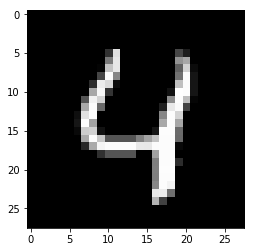

In [20]:
plt.imshow(mnist.test.images[4].reshape(28,28), cmap="gray", interpolation="nearest")
plt.show()

In [37]:
batch_xs, batch_ys = mnist.train.next_batch(batch_size)
X_image = tf.reshape(batch_xs, [-1,28,28,1])

In [7]:
training_batch = zip(range(0, 50000, 128),
                     range(128, 50000+1, 128))
training_batch

In [8]:
batch = 128
for i,j in training_batch:
    print(i,j)

0 128
128 256
256 384
384 512
512 640
640 768
768 896
896 1024
1024 1152
1152 1280
1280 1408
1408 1536
1536 1664
1664 1792
1792 1920
1920 2048
2048 2176
2176 2304
2304 2432
2432 2560
2560 2688
2688 2816
2816 2944
2944 3072
3072 3200
3200 3328
3328 3456
3456 3584
3584 3712
3712 3840
3840 3968
3968 4096
4096 4224
4224 4352
4352 4480
4480 4608
4608 4736
4736 4864
4864 4992
4992 5120
5120 5248
5248 5376
5376 5504
5504 5632
5632 5760
5760 5888
5888 6016
6016 6144
6144 6272
6272 6400
6400 6528
6528 6656
6656 6784
6784 6912
6912 7040
7040 7168
7168 7296
7296 7424
7424 7552
7552 7680
7680 7808
7808 7936
7936 8064
8064 8192
8192 8320
8320 8448
8448 8576
8576 8704
8704 8832
8832 8960
8960 9088
9088 9216
9216 9344
9344 9472
9472 9600
9600 9728
9728 9856
9856 9984
9984 10112
10112 10240
10240 10368
10368 10496
10496 10624
10624 10752
10752 10880
10880 11008
11008 11136
11136 11264
11264 11392
11392 11520
11520 11648
11648 11776
11776 11904
11904 12032
12032 12160
12160 12288
12288 12416
12416 1254

In [14]:
np.arange(100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [8]:
range(training_epochs)

range(0, 20)